# 2D Schrodinger Equation solver

### 1. Initialize and set potential

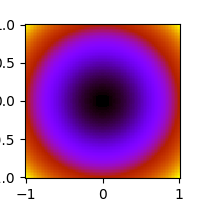

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.animation import FuncAnimation
%matplotlib ipympl


N = 100
X, Y = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))
dx = X[0][1]-X[0][0]

def pd(psi):
    return np.abs(psi)**2

def get_potential(x, y):
    # return 100*(np.abs(x-0.7)<dx)#*(np.abs(y-0.2)>0.1)*(np.abs(y+0.2)>0.1)
    return X**2 + Y**2
    # return 1000*((np.abs(X) > 0.75) | (np.abs(Y) > 0.75))
    # return 0*X

V = get_potential(X,Y)
plt.figure(figsize=(2,2))
plt.pcolormesh(X,Y,V,cmap='gnuplot')

### 2. Create Hamiltonian matrix and find eigenstates

In [2]:
maxk = 100

diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = scipy.sparse.spdiags(diags, np.array([-1,0,1]),N,N)
T = -1/2 * scipy.sparse.kronsum(D,D)
U = scipy.sparse.diags(V.reshape(N**2), (0))
H = T + U

eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(H, k=maxk, which='SM')

eigenvectors = eigenvectors / np.sqrt(dx*dx*np.sum(np.abs(eigenvectors)**2, axis=0))
eigenvectors = np.transpose(eigenvectors)

eigenvectors = eigenvectors[eigenvalues.argsort()]
eigenvalues.sort()

### 3. Plot

MovieWriter ffmpeg unavailable; using Pillow instead.


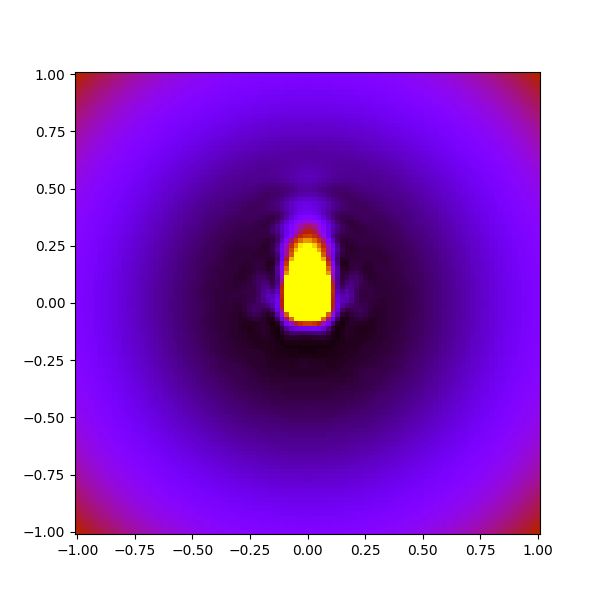

In [4]:
def decompose(psi):
    return [np.sum(dx * np.conj(ev) * psi) for ev in eigenvectors]

def timeEvol(ket, time, n=1):
    res = np.zeros(maxk, dtype=np.complex128)
    for t in range(n):
        for i in range(0,maxk):
            res[i] = np.exp(-1j * eigenvalues[i] * time)
        ket = res * ket
    return ket

psi = np.resize(np.exp(-(X)**2/(2*0.2)**2 - (Y-0.3)**2/(2*0.2)**2) + 1j * 0.0 * X, N**2)
psi /= np.sqrt(np.sum(pd(psi)*dx*dx))
psiket = decompose(psi)

dt = 5
fig, ax = plt.subplots(figsize=(6,6))

l = ax.pcolormesh(X, Y, np.resize(pd(psi), (N,N)), cmap='gnuplot')

def animate(frame, psiket, eigenvectors):
    psiket1 = timeEvol(psiket, dt, frame)
    psi = np.dot(psiket1, eigenvectors)
    psi /= np.sqrt(np.sum(pd(psi)*dx*dx))
    l.set_array(pd(psi)+np.reshape(V,N**2))

def init():
    return ax.pcolormesh(X,Y,V,cmap='gnuplot')

ani = FuncAnimation(fig, animate, frames=100, 
                    interval=1000/60, blit=False, repeat=False,
                    fargs=(psiket, eigenvectors))
ani.save("anim2d.gif")
plt.show()